<h1 style="text-align:center"> Credit Card Fraud Detection </h1>

<p style='text-align:center'>
Feb 2024 <br /><br />
By: Kevin Kan
</p>



<h2 style='font-weight:bold'> Overview </h2>

Using a highly imbalanced dataset containing almost 300,000 transactions made by credit cards in Europe, the goal was to create a model that could reliably detect fraudulent transactions. F1-score was considered to be the most appropriate evaluation metric as it was assumed that both the cost of missing a fraudulent transaction (false negative), and the cost of correcting an incorrectly flagged fraudulent transaction (false positive) is high. A random forest classifier was built and hyperparameter tuned with bayesian optimization and stratified 5-fold cross-validation on a 80/20 split of training/test data. The f1-score on the test set was found to be 0.76. 

Recall score can also be used if only the cost of false negatives is important. Tuning the model for recall instead of f1-score gives a recall score of 0.93 on the test set. 

Potential improvements to the models are also discussed. 

<h2 id='ProjectDescription' style="font-weight:bold"> 1. Project Description </h2>

<p> Using the <a href="hhttps://www.kaggle.com/datasets/mlg-ulb/creditcardfraud"> "Credit Card Fraud Detection" dataset from Kaggle</a> the purpose of this project was to create a model that could reliably detect fraud. It is important for credit card companies to be able to recognize fraudulent transactions so that customers are not charged for items they did not purchase.
</p>

<h2 style='font-weight:bold'> 2. Data Description </h2>
<p> The dataset contains transactions made by credit cards in September 2013 by European cardholders. The dataset presents transactions that occured in 2 days, where we have 492 fraudulent cases out of 284,807 transactions. This dataset is highly imbalanced as this fraudulent cases make up approximately 0.172% of the total transactions.

<br /> For more information on the dataset, please refer to this <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">Kaggle</a>

</p>

<h3 style='font-weight:bold'>2.1 Interpreting Data</h3>

<h4 style='font-weight:bold'><u>Previewing Dataframe</u></h4>

The dataset provided by kaggle as explained above has 31 numeric features, 28 of which are principal components of the original dataset. 

Due to confidentiality reasons, the original dataset had principal components obtained through PCA and are represented through the features V1-V28. Principal component analysis (PCA) is a linear dimensionality reduction method. At its core, it utlizes linear algebra to reduce the amount of features in a dataset while doing its best preserve the information provided by them. Part of the process also minimizes collinearity which is further discussed later on. Because V1-V28 are principal components, we have lost all semantic meaning behind them. The only three original features that remained unmodified are "Time", "Amount", and "Class". The feature "Time" contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature "Amount" represents the transaction amount. Lastly, the feature "Class" is the binary response variable that indicates a fraudulent transaction when it is marked as "1". 

You can refer to this <a href='https://www.youtube.com/watch?v=FgakZw6K1QQ'>video</a> by StatQuest/ Josh Starmer for a more detailed and intuitive explanation of PCA. 

Below is a preview of the dataset in a dataframe. Later on, we will make some plots to visualize some of the data.

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [2]:
df_raw = pd.read_csv('creditcard.csv', delimiter=None)
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h4 style='font-weight:bold'><u>Missing Values</u></h4>

<p>
Now that we've seen what the data looks like in a dataframe, lets check for some irregularities. Firstly, let's check if there are any missing values. From the code below, we can see that there are no null values or any other data points that would represent a missing value (to the best of our knowledge). 
</p>

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<h4 style='font-weight:bold'><u>Checking Class Imbalance</u></h4>

Since this is a classification task, class imbalance plays a major role in affecting how we preprocess our data, how we choose our models, and how we interpret what is a good model. More on class imbalance will be discussed later. For now, let's verify that our response variable "Class" is highly imbalanced. From the code below, we can confirm that this is a highly imbalanced dataset. 

In [4]:
df_raw['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

<h4 style='font-weight:bold'><u>Visualizing Features</u></h4>

To gain insights into our dataset, it can be helpful to explore the distribution of features with respect to fraudulent and non-fraudulent transactions. Understanding how each feature behaves across these two categories can reveal potential patterns that differentiate fraudulent cases from legitimate ones.

Given that our dataset consists exclusively of numeric features, we can plot the probability mass functions (PMFs) for each feature, separated into the two transaction categories. This approach allows us to normalize the data representations, making it easier to compare the distributions despite the class imbalance.

The resulting plots reveal distinct PMFs for many features when comparing fraudulent to non-fraudulent transactions. Because the PMFs are discernable from one another, this suggests that these features could be material in enabling our predictive models to effectively identify fraudulent activity. 

In [ ]:
# The output of this cell is hidden
# The output creates graphs that are too large to host on GitHub. Re-run this notebook to look at the graphs. Refer to the README.md file for instructions.

cols = df_raw.columns.drop('Class')

for i in range(0, len(cols), 2):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(cols[i], cols[i + 1] if i + 1 < len(cols) else ''))

    fig.add_trace(go.Histogram(x=df_raw[df_raw['Class'] == 0][cols[i]], 
                               name='Non-Fraudulent',
                               marker_color='blue', 
                               opacity=0.6, 
                               histnorm='probability density',
                               nbinsx=150), 
                  row=1, col=1)

    fig.add_trace(go.Histogram(x=df_raw[df_raw['Class'] == 1][cols[i]], 
                               name='Fraudulent', 
                               marker_color='yellow', 
                               opacity=0.6, 
                               histnorm='probability density',
                               nbinsx=150), 
                  row=1, col=1)

    if i > 0:
        fig.data[-1].showlegend = True
        fig.data[-2].showlegend = True

    if i + 1 < len(cols):
        fig.add_trace(go.Histogram(x=df_raw[df_raw['Class'] == 0][cols[i + 1]], 
                                   name='Non-Fraudulent', 
                                   marker_color='blue', 
                                   opacity=0.6, 
                                   histnorm='probability density',
                                   nbinsx=150, 
                                   showlegend=False), 
                      row=1, col=2)

        fig.add_trace(go.Histogram(x=df_raw[df_raw['Class'] == 1][cols[i + 1]], 
                                   name='Fraudulent', 
                                   marker_color='yellow', 
                                   opacity=0.6, 
                                   histnorm='probability density',
                                   nbinsx=150, 
                                   showlegend=False), 
                      row=1, col=2)

    fig.update_layout(title_text='Probability Mass Function of Features', 
                      barmode='overlay',
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

    fig.show()

<h4 style='font-weight:bold'><u>Correlations</u></h4>

In machine learning, correlation measures how two features move together, which can reveal potential relationships useful for predictive modeling. Positive correlation means that as one feature increases, the other tends to increase as well, whereas a negative correlation indicates an inverse relationship. Understanding correlations is vital for feature selection and engineering, as it helps identify which features might have predictive power.

Multicollinearity refers to the presence of highly correlated predictors in a dataset. Many machine leaning algorithms break down due to multicollinearity. For this reason, addressing multicollinearity through techniques such as removing redundant features or applying dimensionality reduction, is crucial for model accuracy, stability, and interpretability. 

However in the case of this dataset, to preserve confidentiality, most of the features have already had PCA applied to them. As explained above, PCA as a dimensionality reducing method that aims to maintain the information provided by the original features. As part of the process, the correlations between the principal components are minimized. Therefore for this dataset, most correlations should be fairly low with the exception of "Time", "Amount" and "Class" having potential to have high correlatiokns with other features. 

From the heatmap below, there are no highly correlated variables. The most correlated variables are "V2" and "Amount" with a correlation of -0.53 which is typically acceptable.


<AxesSubplot: >

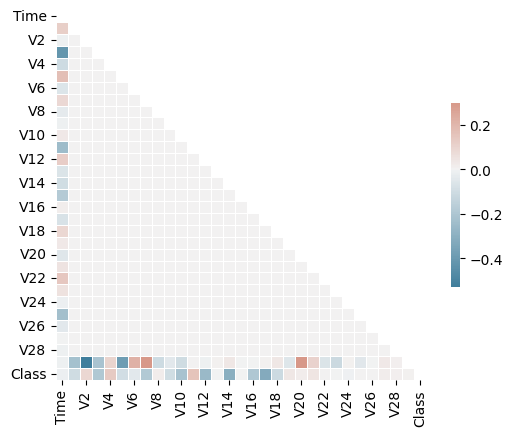

In [6]:
# Generating Correlation Matrix
# No need for correlation matrix and removing features based for multicollinearity as PCA has already been applied on the original features. 

# But just to check for fun...

corr = df_raw.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots()

cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, 
    square = True, linewidth = .5, cbar_kws={'shrink': .5})

In [7]:
corr['V2'].sort_values().head(1)

Amount   -0.531409
Name: V2, dtype: float64

<h2 style='font-weight:bold'> 3. Methodology </h2>

<p>
Below is a general outline of the steps that were used to build a classification model. This section describes the methods used and the choices behind them. 
</p>

<ol>
    <li style='font-weight:bold'>Data Preprocessing</li>
        <ul>
            <li>Data Cleaning</li>
            <li>Feature Selection</li>
            <li>Data Partitioning</li>
            <li>Preprocessing Pipeline</li>
        </ul>
    <li style='font-weight:bold'>Model Selection</li>
        <ul>
            <li>Choosing Learning Algorithms / ANN </li>
            <li>Hyperparameter Tuning and Cross-Validation</li>
        </ul>
</ol>



<h3 style='font-weight:bold'>3.1 Data Preprocessing</h3>

<h4 style='font-weight:bold'><u>Data Cleaning</u></h4>

Data cleaning is a fundamental step before any data can be used to build a model. The model can only perform well if the data it is trained on can provide valid and material information. This process involves identifying and correcting errors, dealing with missing values, removing duplicates, and standardizing data formats. 

Removing invalid data points is crucial as it introduces bias towards the model. Outliers may sometimes be considered as a subset of these data points and are considered for removal as it can at times improve the accuracy of the model. However, outliers also often contain information that is desirable for a model to learn. The choice of outlier removal depends on domain specific knowledge. For this reason, in the case of this fraud dataset where for confidentiality reasons almost all of the features are simply PCA components, no data points were removed.

<h4 style='font-weight:bold'><u>Feature Selection</u></h4>

Feature selection in the development of machine learning models is aimed at identifying the most relevant features that contribute to the predictive power of the model. By eliminating redundant, irrelevant, or noisy data, feature selection helps improve model performance, reduce complexity, and may enhance interpretability. This process not only speeds up model training but also decreases the risk of overfitting, ensuring that the model generalizes well to new, unseen data. 

There are many methods of feature selection. Excluding those that are embedded into learning algorithms, these include:

<ul>
    <li>Filtering through statistical measures</li>
    <li>Wrapper Methods</li>
    <li>Dimensionality Reduction</li>
    <li>Removing features based on domain knowledge</li>
</ul>

For the purpose of this project, details on these methods will not be covered. Once again, dimensionality reduction has already been applied through PCA, which also makes removing features based on domain knowledge impossible. Wrapper methods while feasible will not be applied as it takes too much time for my sadly underpowered machine.



<h4 style='font-weight:bold'><u>Data Partitioning</u></h4>

Data partitioning, which involves splitting the dataset into training and test sets, is a fundamental practice in machine learning to ensure models are accurately evaluated. The training set is used to train the model, allowing it to learn the underlying patterns in the data. The test set serves as unseen data to evaluate the model's performance, providing an unbiased assessment of the model's ability to generalize on new data. This process helps mitigate overfitting, where a model performs well on the training data but poorly on new, unseen data. By partitioning the data and evaluating model performance on a separate test set, we can better estimate how models will perform in real-world scenarios.

Typically, datasets are divided based on a predetermined ratio, such as 70% for training and 30% for testing, although variations like 80/20 or 60/40 are also common depending on the dataset size and specific requirements of the analysis. For this project, the 80/20 split was adopted. The reason for this is because 5-fold cross validation will be used later on for hyper-parameter tuning and will be further discussed later on. 










In [8]:
df = df_raw

X = df.drop(['Class'], axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 888)



In [9]:
y_train.value_counts(), y_test.value_counts()

(0    227458
 1       387
 Name: Class, dtype: int64,
 0    56857
 1      105
 Name: Class, dtype: int64)

<h4 style='font-weight:bold'><u>Preprocessing Pipeline</u></h4>

<em style='font-weight:bold'>Scaling Data</em><br />

Now that we have the training data, there are a few things that need to be addressed before the data can be used to createa  model. Firstly, the data should needs to be scaled properly. Many machine learning algorithms, for various reasons, learn inefficiently and perform suboptimally when trained on unscaled data. For example logistic regression, which is used later on, use gradient descent for optimization. Without scaling, features with large numeric ranges dominate the gradient descent calculations which can lead to slower convergence and suboptimal solutions. Distance based alogorithms like k-nearest neighbors also suffer from unscaled features that disproportionally influence thier distance metric. 

For the features that are principal components of the original features, these features should already be scaled as it is part of the PCA process. For the features "Time", and "Amount", both were standardized. The response variable does not get scaled. Typically, scaling is first fitted to the training set, establishing the parameters based on the data. These same scaling parameters are then consistently applied to the test set. This approach ensures that the model is evaluated on data that is processed in the same way as the data it was trained on, maintaining the integrity of the datasets.


In [10]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 888)

preprocesser = ColumnTransformer(
    transformers = [
        ('scaled', StandardScaler(), ['Time', 'Amount']) 
    ],
    remainder = 'passthrough'
)


<em style='font-weight: bold'>Class Imbalance</em>

Class balance refers to the distribution of classes within a dataset, particularly in classification problems. This imbalance can pose challenges for machine learning algorithms, as models might become biased towards the majority class, leading to poor performance on the minority class. Furthermore, some performance metrics of models lose their meaning on imbalanced datasets (which will be further discussed in another section). This issue is especially critical in applications where correctly identifying the minority class is important, such as fraud detection. 

For this dataset, the non-fraudulent cases are the overwhelming majority and represent 99.828% of the entire dataset. There are generally there are two categories of methods to handle class imbalance: under-sampling and over-sampling. Undersampling is a technique used to address class imbalance by reducing the size of the majority class to match the minority class, thereby equalizing their distributions. This approach can improve model performance on the minority class but risks losing potentially valuable information from the majority class due to the removal of data points. Oversampling combats class imbalance by augmenting the minority class through the replication of its data points or generating synthetic samples, aiming to match the size of the majority class. While this method enhances the model's sensitivity to the minority class, it may introduce the risk of overfitting due to the duplication or artificial creation of data. There are also hybrid methods that use both undersampling and oversampling. 

For the purpose of this project, oversampling with SMOTE was primarirly used. SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling method that generates synthetic samples for the minority class by interpolating between existing minority instances. This approach effectively increases the diversity of the minority class, helping to alleviate class imbalance without the risk of overfitting associated with simple duplication.

The entire pipeline is shown below in Model Selection.


<h3 style='fontweight-bold'>3.2 Model Selection</h3>



<h4 style='font-weight:bold'><u>Choosing Learning Algorithms / ANN</u></h4>


Choosing a learning algorithm involves considering the nature of the dataset, the problem type (classification, regression, clustering, etc.), and the specific requirements of the application, including accuracy, interpretability, and computational efficiency. For this project, both **Logistic Regression** and **Random Forest Classifier** were tested.

<em style='font-weight:bold'>Logistic Regression</em>

As this is a binary classification problem with a relatively large dataset, logistic regression is a suitable algorithm. Logistic regression is powerful when the relationship between the features and the log odds of the response variable is linear. Logistic regression is also favored for its simplicity, interpretability, and efficiency, making it an excellent choice for cases where understanding the influence of each feature on the prediction is crucial. However for this scenario interpretibility isn't an important factor. Nonetheless, logistic regression is used in this project particularly for its computation time. 

<em style='font-weight:bold'>Clustering Algorithms</em>

Other algorithms that could be considered include cliustering algorithms such as k-nearest neighbor classifier. kNN, like most other clustering algorithms, are powerful when the relationship between the features and the response variable is non-linear. However, some changes to the dataset may be required for this algorithm. Clustering algorithms suffer from something referred to as "curse of dimensionality". The performance of clustering algorithms deteriorate with an increase of features due to the sparcity of high-dimensional space. They are also more suitable for smaller datasets as it can become very computationally expensive. For this reason, clustering alogrithms were not tested in this project.

<em style='font-weight:bold'>Tree Algorithms</em>

Tree-based algorithms, such as Decision Trees, Random Forests, and Gradient Boosting Machines (GBMs), are versatile and powerful models suitable for both classification and regression tasks. These algorithms can handle datasets with a wide range of features, including both numerical and categorical data, without the need for extensive preprocessing like normalization or scaling. They are particularly adept at modeling complex, nonlinear relationships and interactions between features due to their hierarchical, divide-and-conquer approach.

Tree algorithms excel in scenarios where interpretability is important, as in the case of decision trees, which provide clear, logical rules for prediction. For datasets with a high number of features, ensemble methods like Random Forests and GBMs can improve performance by aggregating multiple trees to reduce variance and avoid overfitting, making them robust against the curse of dimensionality to some extent.

Regarding dataset size, tree-based models are scalable and can handle large datasets efficiently, especially with algorithms designed for parallel computation like XGBoost. However, extremely large datasets may require careful tuning of parameters like tree depth and the number of trees to balance model complexity and computational efficiency.

<em style='font-weight:bold'>Other</em>

There are also other traditional machine learning algorithms such as SVM that are apporpriate for classification tasks. However they are not implemented in this project and are not discussed. However, if one was to implement these alogorithms, changes to the dataset may be necessary to reduce computational load (reduce features and/or take a subset of the dataset).

<em style='font-weight:bold'>Deep Learning</em>

Deep learning algorithms, powered by neural networks with multiple layers, are exceptionally well-suited for handling complex and high-dimensional data. They excel in tasks where the relationships and patterns within the data are too intricate for traditional machine learning algorithms to capture. Deep learning is particularly effective for large datasets, as the abundance of data allows the network to learn a wide variety of features and representations at different levels of abstraction, from simple patterns in the early layers to highly complex features in deeper layers.

However, the strength of deep learning comes with the requirement for substantial computational resources, particularly for training large models on big datasets. They also require careful tuning of network architecture and hyperparameters, as well as strategies to prevent overfitting. Moreover, there are less interpretable than some traditonal machine learning algorithms. Deep learning is most appropriate for applications where the complexity and size of the dataset justify the computational expense, and where the task benefits from the model's ability to learn rich, hierarchical representations of the data. In the case of credit fraud classification, this is most likely not necessary. 

<h4 style='font-weight:bold'><u>Choosing Evaluation Metrics</u></h4>

Choosing an appropriate evaluation metric is critical as it determines how the performance of a model is defined. For classification tasks, 4 common metrics are:

<ul>
    <li> Accuracy </li>
    <li> Precision </li>
    <li> Recall </li>
    <li style='font-weight:bold'> F1-Score <-- This was chosen</li>
</ul>

Accuracy is commonly used and probably the most intuitive and interpretable. Accuracy represents the percentage of correct predictions the model makes. In other words, it is the number of true positives and true negatives with respect to the total number of predictions. However for imbalanced datasets, accuracy is not effectively useless. Consider our current dataset where one class makes up 98.828% of the data available (non-fraudulent transactions). Now assume a naive model where every single transaction is classified as non-fraudulent. The accuracy of the naive model on our dataset would have an accuracy of 98.828%! However, this is effectively a useless model as the purpose of this project is to reliably classify fraudulent transactions. 

Precision refers to the proportion of true positive outcomes in the total predicted positives. It measures the accuracy of the positive predictions made by a classification model, indicating how many of the items identified as positive are actually positive. High precision means that the model has a low rate of false positives, which is particularly important in scenarios where the cost of falsely identifying negatives as positives is high.

Recall, also known as sensitivity, measures the proportion of actual positives that are correctly identified by the model. It assesses the model's ability to detect positive instances among all actual positives, highlighting its sensitivity to catching positive cases. High recall indicates that the model successfully identifies most positives, which is crucial in situations where missing a positive instance carries a significant cost.

F1-score is the chosen evaluation metric for this classification task. The F1-score is a harmonic mean of precision and recall, serving as a single metric that balances the two. It is particularly useful when you need to consider both false positives and false negatives equally (which is what is assumed in this case for fraud detection), or when working with imbalanced datasets where one class significantly outnumbers the other. 


<h4 style='font-weight:bold'><u>Hyperparameter Tuning with Cross-Validation</u></h4>

Hyperparameter tuning is a crucial step in the machine learning workflow. It involves the optimization of the parameters that govern the learning process and architecture of a model. Unlike model parameters, which are learned from the data during training, hyperparameters are set prior to the training process and can significantly affect model performance. The goal of hyperparameter tuning is to find the optimal combination of hyperparameters that results in the best predictive performance on a given task. Common techniques for hyperparameter tuning include grid search, where a set of predefined hyperparameter values are exhaustively tried; random search, which samples hyperparameter combinations at random for a specified number of iterations; and Bayesian optimization, a more sophisticated approach that models the performance function and selects hyperparameters to test based on past results. Effective hyperparameter tuning can lead to significant improvements in model accuracy, efficiency, and generalization to new data.

Bayesian optimization is used in this project as it is generally a superior method for hyperparameter tuning due to its efficiency and effectiveness, particularly in scenarios where evaluating the performance of a model is computationally expensive. Unlike grid search or random search, which either exhaustively or randomly explore the hyperparameter space, Bayesian optimization uses prior evaluations of the hyperparameter space to inform the next set of hyperparameters to explore. This probabilistic model approach aims to predict the performance of various hyperparameter combinations and chooses the next evaluation to balance exploration of new areas with exploitation of known promising areas. Bayesian optimization can reach optimal or near-optimal hyperparameter settings faster and with fewer evaluations, making it an especially valuable tool for optimizing complex models where each evaluation can be time-consuming and resource-intensive.







<em style='font-weight:bold'>Logistic Regression<em>

As described above, the preprocessing pipeline is shown below.

In [11]:
# Logistic Regression

logreg_pipe = ImbPipeline(steps = [
    ('preprocesser', preprocesser),
    ('oversample', SMOTE(random_state = 888)),
    ('logreg', LogisticRegression(random_state = 888, max_iter = 1000)) 
])


The below code block defines the range of hyperparameters that are used in Bayesian optimization. Bayesian optimization is used along with 5 stratified folds for cross-validation. Cross-validation is a robust technique used to assess the generalizability and performance of machine learning models. By partitioning the available data into a set number of subsets or "folds," models are trained on several combinations of these folds and tested on the remaining parts, ensuring that every data point is used for both training and validation exactly once. This method helps mitigate overfitting and provides a more accurate measure of a model's predictive performance on unseen data. Stratified folds essentially mean that each "fold" or partition has an equivalent proportion of samples from each class as the original dataset which is important for imbalanced datasets. 

Note that the class balancing using the oversampling method, SMOTE, is used during the cross-validation process. The cross-validation process also optimizes the model's hyperparameters for the highest F1 score. It is essentially a classification evaluation metric appropriate for imbalanced datasets, and what is used for this project. Once this process is done, a model is fitted with the 'optimal' hyperparameters and its F1 score on the training data is found and shown below. The model can then be used on a test set. 

The tuned logistic regression model has an F1-score of approximately 0.75 on the training set.

In [12]:

logreg_search_space = {
    'logreg__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'logreg__solver': Categorical(['liblinear', 'lbfgs'])
}

logreg_bcv = BayesSearchCV(
    estimator = logreg_pipe,
    search_spaces = logreg_search_space,
    scoring = 'f1',
    cv = skf,
    n_iter = 50, 
    n_jobs = -1,
    verbose = 0,
    random_state = 888
)

logreg_bcv.fit(X_train, y_train)

print("Best parameters found: ", logreg_bcv.best_params_)
print("Best score found: ", logreg_bcv.best_score_)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/

Best parameters found:  OrderedDict([('logreg__C', 1e-06), ('logreg__solver', 'lbfgs')])
Best score found:  0.8022670096839699


The hyperparameter tuned logistic regression model was then used to predict on the test set and had an F1-score of approximately 0.74. 

In [13]:
y_pred = logreg_bcv.predict(X_test)

test_f1 = f1_score(y_test, y_pred)
print(f"F1 on Test Set: {test_f1}")
test_recall = recall_score(y_test, y_pred)
print(f"Recall on Test Set: {test_recall}")

F1 on Test Set: 0.7441860465116279
Recall on Test Set: 0.7619047619047619


Below shows a heatmap of the confusion matrix generated from the predictions of the logistic regression model on the test set. 

LogReg Confusion Matrix


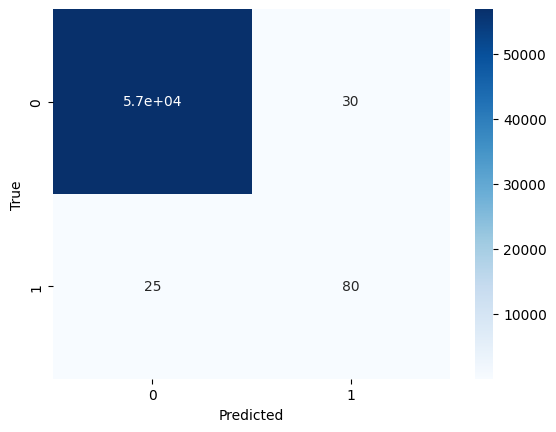

In [14]:
logreg_cm = confusion_matrix(y_test, y_pred)

print('LogReg Confusion Matrix')
sns.heatmap(logreg_cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True');

<em style='font-weight:bold'>Random Forest Classifier<em>

Like the logistic regression model shown above, the pipeline for feeding and preprocessing the data into the learning algorithm and hyperparameter tuning are the same. The only differences are that the hyperparameter search space is different (because it's a different learning algorithm) and the number of iterations for bayesian optimization was reduced from 50 to 10. This is to reduce the computational load (I'm running this on a MacBook Pro and I don't want to wait for hours). 

Like for the logistic regression model, the pipeline and hyperparameter search space is shown below in the code. The bayesian cross validation is optimized to find the best f1-score. The f1-score on the training set was found to be approximately 0.81 and is shown below. 

In [15]:
rf_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocesser),
    ('oversample', SMOTE(random_state=888)),
    ('rf', RandomForestClassifier(random_state=888))
])

rf_param = {
    'rf__n_estimators': Integer(10, 200),  
    'rf__max_depth': Integer(5, 20),  
    'rf__min_samples_split': Integer(2, 10), 
    'rf__min_samples_leaf': Integer(1, 6), 
    'rf__max_features': Categorical(['sqrt', 'log2'])  
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)

rf_bcv = BayesSearchCV(
    estimator=rf_pipe,
    search_spaces=rf_param,
    scoring='f1',
    cv=skf,
    n_iter=10,  # Reduced iterations to minimize computation
    n_jobs=-1,
    verbose=0,
    random_state=888
)

rf_bcv.fit(X_train, y_train)

print("Best parameters found: ", rf_bcv.best_params_)
print("Best score found: ", rf_bcv.best_score_)

Best parameters found:  OrderedDict([('rf__max_depth', 17), ('rf__max_features', 'sqrt'), ('rf__min_samples_leaf', 3), ('rf__min_samples_split', 3), ('rf__n_estimators', 94)])
Best score found:  0.8193696315604873


With the fitted and hyperparameter tuned random forest classifier model, the model was then used to predict on the test set. From below, the model has an f1-score of 0.76 which is slightly better than the logistic regression model. 

<em>Note: This model was also experimented on to tune for recall and it was found that the recall score on the test set was 0.93!</em>

In [16]:
y_pred = rf_bcv.predict(X_test)

test_f1 = f1_score(y_test, y_pred)
print(f"F1 on Test Set: {test_f1}")
test_recall = recall_score(y_test, y_pred)
print(f"Recall on Test Set: {test_recall}")

F1 on Test Set: 0.7614678899082569
Recall on Test Set: 0.7904761904761904


A heatmap of the confusion matrix for the predictions by the random forest model is shown below. 

Random Forest Confusion Matrix


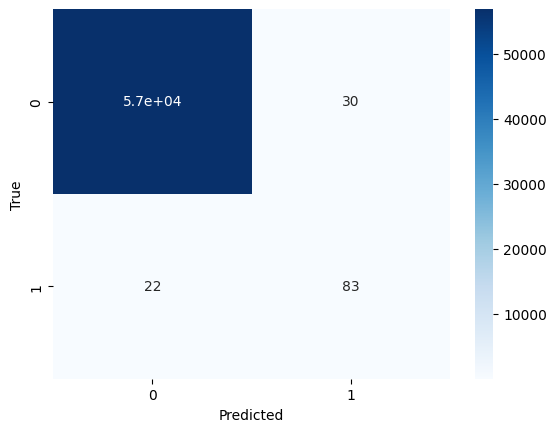

In [17]:
rf_cm = confusion_matrix(y_test, y_pred)

print('Random Forest Confusion Matrix')
sns.heatmap(rf_cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True');

<h2 style='font-weight:bold'>4. Recommendations and Conclusion</h2>

With a highly imbalanced dataset with almost 300,000 credit card transactions, the purpose of this project was to create a machine learning model that could reliably detect fraudulent transactions. The dataset was assumed to be cleaned as the features in this dataset are PCA components of the original for confidentiality reasons. Using a 80/20 split of training/testing data, two classifiers (logistic regression and random forest) were built, trained and tested with F1-score as its evaluation metric. The data was first scaled, then fed into a stratified 5-fold cross-validation using SMOTE to handle the class imbalance and bayesian optimization for hyperparameter tuning. The random forest classifier was found to perform slighly better than the logistic regression model with a F1-score of 0.76. 

To potentially improve on this classification model, several changes can be made and tried. Firstly, modifications to the dataset can be made. As mentioned earlier, feature selection plays a major factor in model performance. Testing with different subsets of features can improve the model performance and avoid overfitting. Furthermore, changing the sample size of the training data can also improve performance. Currently, the random forest classification model uses all available data points. Because the dataset is so highly imbalanced, using SMOTE may overfit the model to the training data as SMOTE synthetically creates new datapoints by interpolating between fraudulent transactions. A hybrid method of undersampling then oversampling may improve model performance. Furthermore, expanding the search space of the hyperparameters may also improve performance

Other learning algorithms may also perform better than the ones that were tested in this project. For example, artificial neural networks (ANN) are very powerful and with tuning are likely to perform better than our current model. However, they are also computationally intensive. These trade-offs must be considered when choosing a learning algorithm. 

Lastly, my domain knowledge of fraud detection is fairly limited. It's possible that the cost of missing a fraudulent transaction is much more costly than checking if a transaction is fraudulent. In that case, recall can be used as the appropriate evaluation metric. The models can then be tuned for recall instead of F1-score. The evaluation metric should be determined by an understanding of the problem at hand. 